In [39]:
from dotenv import load_dotenv
load_dotenv()

from langchain_community.graphs import Neo4jGraph

# Warning Control
import warnings
warnings.filterwarnings("ignore")

## Setup and Configuration

First, we'll load environment variables and configure our Neo4j connection.

# Graph Database Analysis with Neo4j and Cypher

This notebook demonstrates how to query and analyze graph databases using Neo4j and the Cypher query language. We'll explore a movie dataset containing information about films, actors, directors, producers, and writers.

## Dataset Overview

- **Nodes**: 45 total
  - 7 Movie nodes (The Matrix trilogy, Top Gun, Jerry Maguire, A Few Good Men, The Devil's Advocate)
  - 38 Person nodes (actors, directors, producers, writers)
- **Relationships**: ACTED_IN, DIRECTED, PRODUCED, WROTE

## Learning Objectives

By the end of this notebook, you'll understand:
- Basic Cypher query patterns (MATCH, WHERE, RETURN)
- Aggregation functions (COUNT, COLLECT, AVG)
- Path finding and graph traversal
- Centrality metrics (degree and betweenness centrality)
- Advanced pattern matching and filtering

Let's get started!

In [40]:
import os

NEO4J_URI = os.getenv('NEO4J_URI')
NEO4J_USERNAME = os.getenv('NEO4J_USERNAME')
NEO4J_PASSWORD = os.getenv('NEO4J_PASSWORD')
NEO4J_DATABASE = os.getenv('NEO4J_DATABASE')

Initialize a knowledge graph instance using Langchain's Neo4j integration

In [41]:
kg = Neo4jGraph(url=NEO4J_URI, username=NEO4J_USERNAME, password=NEO4J_PASSWORD, database=NEO4J_DATABASE)

## Querying the movie knowledge graph 

Match all the nodes in the graph

In [42]:
cypher = """
match (n)
return count(n)
"""

In [43]:
result = kg.query(cypher)
result

[{'count(n)': 45}]

In [44]:
cypher = """
match (n)
return count(n) as number_of_nodes
"""

In [45]:
result = kg.query(cypher)
result

[{'number_of_nodes': 45}]

In [46]:
print(f"There are {result[0]['number_of_nodes']} nodes in this graph.")

There are 45 nodes in this graph.


In [47]:
cypher = """
match (n:Movie)
return count(n) as number_of_movies
"""
kg.query(cypher)

[{'number_of_movies': 7}]

Match only the `Person` nodes in the graph

In [48]:
cypher = """
match (person: Person)
return count(person) as number_of_people
"""
kg.query(cypher)

[{'number_of_people': 38}]

Match a single person by specifying the value of the name property on the Person node

In [49]:
cypher = """
match (keanu: Person {name:"Keanu Reeves"})
return keanu
"""
kg.query(cypher)

[{'keanu': {'born': 1964, 'name': 'Keanu Reeves'}}]

Match a single Movie by specifying the value of the title property

In [50]:
cypher = """
match (movie: Movie {title: "The Matrix"})
return movie
"""
kg.query(cypher)

[{'movie': {'tagline': 'Welcome to the Real World',
   'title': 'The Matrix',
   'released': 1999}}]

## Cypher patterns with conditional matching

In [51]:
cypher = """
match (movie: Movie)
where movie.released > 2000
return movie
""" 
kg.query(cypher)

[{'movie': {'tagline': 'Free your mind',
   'title': 'The Matrix Reloaded',
   'released': 2003}},
 {'movie': {'tagline': 'Everything that has a beginning has an end',
   'title': 'The Matrix Revolutions',
   'released': 2003}}]

## Pattern matching with multiple nodes

In [52]:
cypher = """
match (keanu: Person {name: 'Keanu Reeves'}) -[:ACTED_IN]-> (movie)
return keanu.name, movie.title
""" 
kg.query(cypher)

[{'keanu.name': 'Keanu Reeves', 'movie.title': 'The Matrix'},
 {'keanu.name': 'Keanu Reeves', 'movie.title': 'The Matrix Reloaded'},
 {'keanu.name': 'Keanu Reeves', 'movie.title': 'The Matrix Revolutions'},
 {'keanu.name': 'Keanu Reeves', 'movie.title': "The Devil's Advocate"}]

In [53]:
# Result: Your database now has:
#   - 45 total nodes
#     - 7 Movie nodes (The Matrix trilogy, Top Gun, Jerry Maguire, etc.)
#     - 38 Person nodes (actors, directors, producers)
#   - Relationships: ACTED_IN, DIRECTED, PRODUCED, WROTE

## Understanding COLLECT() and OPTIONAL MATCH

### The Problem with MATCH
When you use `MATCH` for multiple relationships, Cypher creates a **Cartesian product**. 

Example: If a movie has 2 directors and 1 producer, you get **2 rows** (one per director), duplicating the producer information.

### The Solution: COLLECT() + OPTIONAL MATCH

- **`OPTIONAL MATCH`**: Like SQL's LEFT JOIN - returns the row even if the relationship doesn't exist (value = null)
- **`COLLECT()`**: Aggregation function that groups multiple values into a single list
- **`DISTINCT`**: Removes duplicates within the collected list

This pattern lets us get **one row per movie** with all directors/producers/writers in neat arrays!

In [54]:
cypher = """
match (keanu: Person {name: 'Keanu Reeves'}) -[:ACTED_IN]-> (movie)
optional match (movie)<-[:DIRECTED]-(director: Person)
optional match (movie)<-[:PRODUCED]-(producer: Person)
optional match (movie)<-[:WROTE]-(writer: Person)
return 
    keanu.name, 
    movie.title, 
    collect(distinct director.name) as directors, 
    collect(distinct producer.name) as producers, 
    collect(distinct writer.name) as writers
""" 
kg.query(cypher)

[{'keanu.name': 'Keanu Reeves',
  'movie.title': 'The Matrix',
  'directors': ['Lilly Wachowski', 'Lana Wachowski'],
  'producers': ['Joel Silver'],
  'writers': []},
 {'keanu.name': 'Keanu Reeves',
  'movie.title': 'The Matrix Reloaded',
  'directors': ['Lilly Wachowski', 'Lana Wachowski'],
  'producers': ['Joel Silver'],
  'writers': []},
 {'keanu.name': 'Keanu Reeves',
  'movie.title': 'The Matrix Revolutions',
  'directors': ['Lilly Wachowski', 'Lana Wachowski'],
  'producers': ['Joel Silver'],
  'writers': []},
 {'keanu.name': 'Keanu Reeves',
  'movie.title': "The Devil's Advocate",
  'directors': ['Taylor Hackford'],
  'producers': [],
  'writers': []}]

# Graph Analysis Exercises

Let's analyze the movie dataset using Cypher queries ranging from easy to hard. Each section includes educational insights about the Cypher patterns used.

## Questions Overview

### Easy (Basic Pattern Matching)
1. Which actors appeared in the most movies together?
2. What is the average birth year of all actors in the dataset?
3. Which movies were released in the same year?

### Medium (Path Finding & Aggregations)
4. Find the "degrees of separation" between two actors
5. Which directors have worked with the same actor multiple times?
6. What are the most common roles played by actors?

### Hard (Advanced Graph Algorithms)
7. Find the strongest collaboration networks
8. Identify the most central/influential person (Centrality Metrics)
9. Discover career path transitions (Multiple role analysis)

---

## Easy

1. Which actors appeared in the most movies together? - Find pairs of actors who co-starred frequently

In [55]:
import pandas as pd

In [56]:
cypher = """
match (actor: Person) -[:ACTED_IN]-> (m) <-[:ACTED_IN]-(coStar: Person)
return actor.name, coStar.name, count(*) as coStarCount
order by coStarCount desc
limit 5
"""
result = kg.query(cypher)
df = pd.DataFrame(result)
df

,actor.name,coStar.name,coStarCount
0,Keanu Reeves,Carrie-Anne Moss,3
1,Hugo Weaving,Keanu Reeves,3
2,Laurence Fishburne,Keanu Reeves,3
3,Carrie-Anne Moss,Keanu Reeves,3
4,Laurence Fishburne,Carrie-Anne Moss,3


2. What is the average birth year of all actors in the dataset? - Calculate basic statistics on person data

In [57]:
cypher = """
match (actor) 
where actor.born is not null
return round(avg(actor.born),2) as avg_born
"""
result = kg.query(cypher)
df = pd.DataFrame(result)
df

,avg_born
0,1959.45


3. Which movies were released in the same year? - Group movies by their release year

In [58]:
cypher = """
match (movie:Movie)
return movie.released, count(*) as count, collect(movie.title) as titles
order by movie.released
"""
result = kg.query(cypher)
df = pd.DataFrame(result)
df

,movie.released,count,titles
0,1986,1,[Top Gun]
1,1992,1,[A Few Good Men]
2,1997,1,[The Devil's Advocate]
3,1999,1,[The Matrix]
4,2000,1,[Jerry Maguire]
5,2003,2,"[The Matrix Reloaded, The Matrix Revolutions]"


## Degrees of Separation (Six Degrees of Kevin Bacon)

**Concept**: In graph theory, "degrees of separation" measures how many steps it takes to connect two nodes.

**Famous Example**: "Six Degrees of Kevin Bacon" - the idea that any actor can be connected to Kevin Bacon in 6 steps or less.

### How it works:
- **0 degrees**: Same person
- **1 degree**: Direct co-stars (acted in the same movie)
- **2 degrees**: Friend of a friend (connected through one intermediate person)
- **3+ degrees**: Keep following the chain

### The Query Pattern:
- `shortestPath()`: Finds the shortest path between two nodes
- `[:ACTED_IN*]`: Variable-length path (follow ACTED_IN relationships multiple times)
- `length(path) / 2`: Divide by 2 because path includes both people AND movies

In [59]:
cypher = """
match path = shortestPath(
    (keanu: Person {name: 'Keanu Reeves'}) -[:ACTED_IN*]- (tom: Person {name: 'Carrie-Anne Moss'})
)
return length(path) / 2 as degrees_of_separation, [node in nodes(path)] as connection_chain
"""
result = kg.query(cypher)
df = pd.DataFrame(result)
df

,degrees_of_separation,connection_chain
0,1,"[{'born': 1964, 'name': 'Keanu Reeves'}, {'tag..."


5. Which directors have worked with the same actor multiple times? - Identify director-actor collaborations across different films

In [60]:
cypher = """
match (actor: Person) -[:ACTED_IN]-> (movie: Movie) <-[:DIRECTED]- (director: Person)
with director, actor, count(movie) as collaboration_count, collect(movie.title) as movies
where collaboration_count > 1
return
    director.name as director,
    actor.name as actor,
    collaboration_count,
    movies
order by collaboration_count desc
limit 5
"""
result = kg.query(cypher)
df = pd.DataFrame(result)
df

,director,actor,collaboration_count,movies
0,Lilly Wachowski,Carrie-Anne Moss,3,"[The Matrix, The Matrix Reloaded, The Matrix R..."
1,Lilly Wachowski,Laurence Fishburne,3,"[The Matrix, The Matrix Reloaded, The Matrix R..."
2,Lilly Wachowski,Hugo Weaving,3,"[The Matrix, The Matrix Reloaded, The Matrix R..."
3,Lana Wachowski,Keanu Reeves,3,"[The Matrix, The Matrix Reloaded, The Matrix R..."
4,Lilly Wachowski,Keanu Reeves,3,"[The Matrix, The Matrix Reloaded, The Matrix R..."


## Analyzing Relationship Properties with UNWIND

**Challenge**: The `roles` property in ACTED_IN relationships contains an **array** of character names. How do we analyze individual roles?

**Solution**: Use `UNWIND` to "explode" arrays into individual rows.

### UNWIND Explained:
```
Before UNWIND: roles = ['Neo', 'Trinity']
After UNWIND:  
  Row 1: role = 'Neo'
  Row 2: role = 'Trinity'
```

This lets us:
- Count how many times each character appeared
- Find patterns (e.g., military ranks like "Lt.", "Capt.")
- Aggregate across all movies

**Real-world use case**: Identify typecasting, recurring character archetypes, or franchise continuity.

In [61]:
cypher = """
match (p:Person) -[r:ACTED_IN]-> (m:Movie)
unwind r.roles as role
return 
    role,
    count(*) as times_played,
    collect(distinct p.name) as actors,
    collect(distinct m.title) as movies
order by times_played desc
limit 5
"""
result = kg.query(cypher)
df = pd.DataFrame(result)
df

,role,times_played,actors,movies
0,Neo,3,[Keanu Reeves],"[The Matrix, The Matrix Reloaded, The Matrix R..."
1,Morpheus,3,[Laurence Fishburne],"[The Matrix, The Matrix Reloaded, The Matrix R..."
2,Agent Smith,3,[Hugo Weaving],"[The Matrix, The Matrix Reloaded, The Matrix R..."
3,Trinity,3,[Carrie-Anne Moss],"[The Matrix, The Matrix Reloaded, The Matrix R..."
4,Kevin Lomax,1,[Keanu Reeves],[The Devil's Advocate]


## Hard

7. Find the "collaboration network strength" - Which groups of people have worked together the most across different roles?

Identify clusters of people (actors, directors, producers, writers) who frequently collaborate on movies together, and calculate the strength of their
  professional network based on number of shared projects and diversity of roles.

In [62]:
cypher = """
match (p1: Person) -[r1]- (movie: Movie) -[r2]-(p2: Person)
where id(r1) < id(r2) // avoid counting the same pair twice
with p1, p2,
    count(distinct movie) as no_of_movies_together,
    collect(distinct movie.title) as shared_movies,
    collect(distinct type(r1)) as p1_roles,
    collect(distinct type(r2)) as p2_roles
where no_of_movies_together > 1
return 
    p1.name as person1,
    p2.name as person2,
    no_of_movies_together as collaboration_count,
    shared_movies,
    p1_roles as person1_roles,
    p2_roles as person2_roles,
    size(p1_roles) + size(p2_roles) as role_diversity_score
order by collaboration_count desc, role_diversity_score desc
"""
result = kg.query(cypher)
df = pd.DataFrame(result)
df


Received notification from DBMS server: <GqlStatusObject gql_status='01N01', status_description='warn: feature deprecated with replacement. id is deprecated. It is replaced by elementId or consider using an application-generated id.', position=<SummaryInputPosition line=3, column=7, offset=67>, raw_classification='DEPRECATION', classification=<NotificationClassification.DEPRECATION: 'DEPRECATION'>, raw_severity='WARNING', severity=<NotificationSeverity.WARNING: 'WARNING'>, diagnostic_record={'_classification': 'DEPRECATION', '_severity': 'WARNING', '_position': {'offset': 67, 'line': 3, 'column': 7}, 'OPERATION': '', 'OPERATION_CODE': '0', 'CURRENT_SCHEMA': '/'}> for query: '\nmatch (p1: Person) -[r1]- (movie: Movie) -[r2]-(p2: Person)\nwhere id(r1) < id(r2) // avoid counting the same pair twice\nwith p1, p2,\n    count(distinct movie) as no_of_movies_together,\n    collect(distinct movie.title) as shared_movies,\n    collect(distinct type(r1)) as p1_roles,\n    collect(distinct type(r

,person1,person2,collaboration_count,shared_movies,person1_roles,person2_roles,role_diversity_score
0,Keanu Reeves,Carrie-Anne Moss,3,"[The Matrix, The Matrix Reloaded, The Matrix R...",[ACTED_IN],[ACTED_IN],2
1,Keanu Reeves,Laurence Fishburne,3,"[The Matrix, The Matrix Reloaded, The Matrix R...",[ACTED_IN],[ACTED_IN],2
2,Carrie-Anne Moss,Laurence Fishburne,3,"[The Matrix, The Matrix Reloaded, The Matrix R...",[ACTED_IN],[ACTED_IN],2
3,Keanu Reeves,Hugo Weaving,3,"[The Matrix, The Matrix Reloaded, The Matrix R...",[ACTED_IN],[ACTED_IN],2
4,Carrie-Anne Moss,Hugo Weaving,3,"[The Matrix, The Matrix Reloaded, The Matrix R...",[ACTED_IN],[ACTED_IN],2
5,Laurence Fishburne,Hugo Weaving,3,"[The Matrix, The Matrix Reloaded, The Matrix R...",[ACTED_IN],[ACTED_IN],2
6,Keanu Reeves,Lilly Wachowski,3,"[The Matrix, The Matrix Reloaded, The Matrix R...",[ACTED_IN],[DIRECTED],2
7,Carrie-Anne Moss,Lilly Wachowski,3,"[The Matrix, The Matrix Reloaded, The Matrix R...",[ACTED_IN],[DIRECTED],2
8,Laurence Fishburne,Lilly Wachowski,3,"[The Matrix, The Matrix Reloaded, The Matrix R...",[ACTED_IN],[DIRECTED],2
9,Hugo Weaving,Lilly Wachowski,3,"[The Matrix, The Matrix Reloaded, The Matrix R...",[ACTED_IN],[DIRECTED],2


## Understanding Centrality Metrics

**Question**: Which person acts as the biggest connector/bridge in the network?

In graph theory, **centrality** measures help identify important nodes. Two key metrics are:

### 1. Degree Centrality
**Measures**: Direct connections - "How many movies has this person worked on?"
- Simple count of relationships
- Indicates popularity or activity level
- Example: A prolific actor who works on many films

### 2. Betweenness Centrality  
**Measures**: Bridge/bottleneck - "How many shortest paths between others go through this person?"
- Counts paths where someone appears as a connector
- Indicates structural importance
- Example: Someone who uniquely connects different groups

### Real-World Analogy:
- **Degree Centrality**: A celebrity with many followers (popular)
- **Betweenness Centrality**: A diplomat connecting two countries (strategic)

Let's calculate both metrics and compare!

In [63]:
# Degree Centrality: Count direct connections (movies worked on)
cypher = """
match (p: Person) -[:ACTED_IN|DIRECTED|PRODUCED|WROTE]-(m: Movie)
return p.name as person, count(distinct m) as total_connections
order by total_connections desc
limit 10
"""
result = kg.query(cypher)
df = pd.DataFrame(result)
print("Top 10 People by Degree Centrality (Most Active):")
df

Top 10 People by Degree Centrality (Most Active):


,person,total_connections
0,Keanu Reeves,4
1,Laurence Fishburne,3
2,Hugo Weaving,3
3,Tom Cruise,3
4,Lana Wachowski,3
5,Joel Silver,3
6,Lilly Wachowski,3
7,Carrie-Anne Moss,3
8,Cuba Gooding Jr.,2
9,Taylor Hackford,1


In [64]:
# Betweenness Centrality: Find who appears in the most shortest paths between other people
cypher = """
match (p1: Person), (p2: Person)
where p1 <> p2 and elementId(p1) < elementId(p2)
with p1, p2
match path = shortestPath((p1) -[:ACTED_IN|DIRECTED|PRODUCED|WROTE*..10]-(p2))
where path is not null
with [node in nodes(path) where node: Person | node] as people
unwind people as person
return 
    person.name as connector, 
    count(*) as paths_through_person
order by paths_through_person desc
limit 10
"""
result = kg.query(cypher)
df_betweenness = pd.DataFrame(result)
print("Top 10 People by Betweenness Centrality (Biggest Bridges):")
df_betweenness

Top 10 People by Betweenness Centrality (Biggest Bridges):


,connector,paths_through_person
0,Tom Cruise,255
1,Kevin Pollak,27
2,Keanu Reeves,27
3,Kevin Bacon,27
4,Noah Wyle,27
5,Cuba Gooding Jr.,27
6,Jack Nicholson,27
7,Kiefer Sutherland,27
8,Demi Moore,27
9,J.T. Walsh,27


### Interpreting the Results

**Key Finding**: Tom Cruise has the highest betweenness centrality (255 paths), but Keanu Reeves has the highest degree centrality (4 movies).

#### Why the difference?

**Tom Cruise** acts as a critical **bridge** in the network:
- He connects 3 separate movie clusters: "A Few Good Men" (13 actors), "Top Gun" (6 actors), and "Jerry Maguire" (9 actors)
- Without Tom, these groups would be **disconnected** from each other
- He appears in many paths because he's the **only link** between these clusters

**Keanu Reeves** is the most **prolific**:
- Worked on 4 movies (most in the dataset)
- But his network is smaller and more tightly connected (Matrix trilogy + Devil's Advocate)

#### The Network Structure

Our dataset has **two disconnected components**:
1. **Tom Cruise Universe**: A Few Good Men, Top Gun, Jerry Maguire (~28 people)
2. **Keanu Reeves Universe**: Matrix trilogy, Devil's Advocate (~12 people)

These two universes are **completely separate** - no paths exist between them!

**Conclusion**: 
- High betweenness ≠ Most influential overall
- Tom is central **within his cluster** (bigger cluster = more paths)
- Keanu is more active **across more projects**
- Both metrics provide valuable but different insights!

### Visualizing the Network

Let's create visual representations to better understand the network structure and see why Tom Cruise has high betweenness centrality.

In [65]:
# Note: Uncomment and run this cell if you need to install required packages
# !pip install networkx matplotlib

In [66]:
import networkx as nx
import matplotlib.pyplot as plt

# Fetch the graph data
query = """
MATCH (p:Person)-[r]-(m:Movie)
RETURN p.name as person, m.title as movie, type(r) as relationship
"""
graph_data = kg.query(query)

# Build NetworkX graph
G = nx.Graph()
person_nodes = set()
movie_nodes = set()

for row in graph_data:
    person = row['person']
    movie = row['movie']
    person_nodes.add(person)
    movie_nodes.add(movie)
    G.add_edge(person, movie)

print(f"Graph has {len(person_nodes)} people and {len(movie_nodes)} movies")
print(f"Total nodes: {G.number_of_nodes()}, Total edges: {G.number_of_edges()}")

Graph has 38 people and 7 movies
Total nodes: 45, Total edges: 56


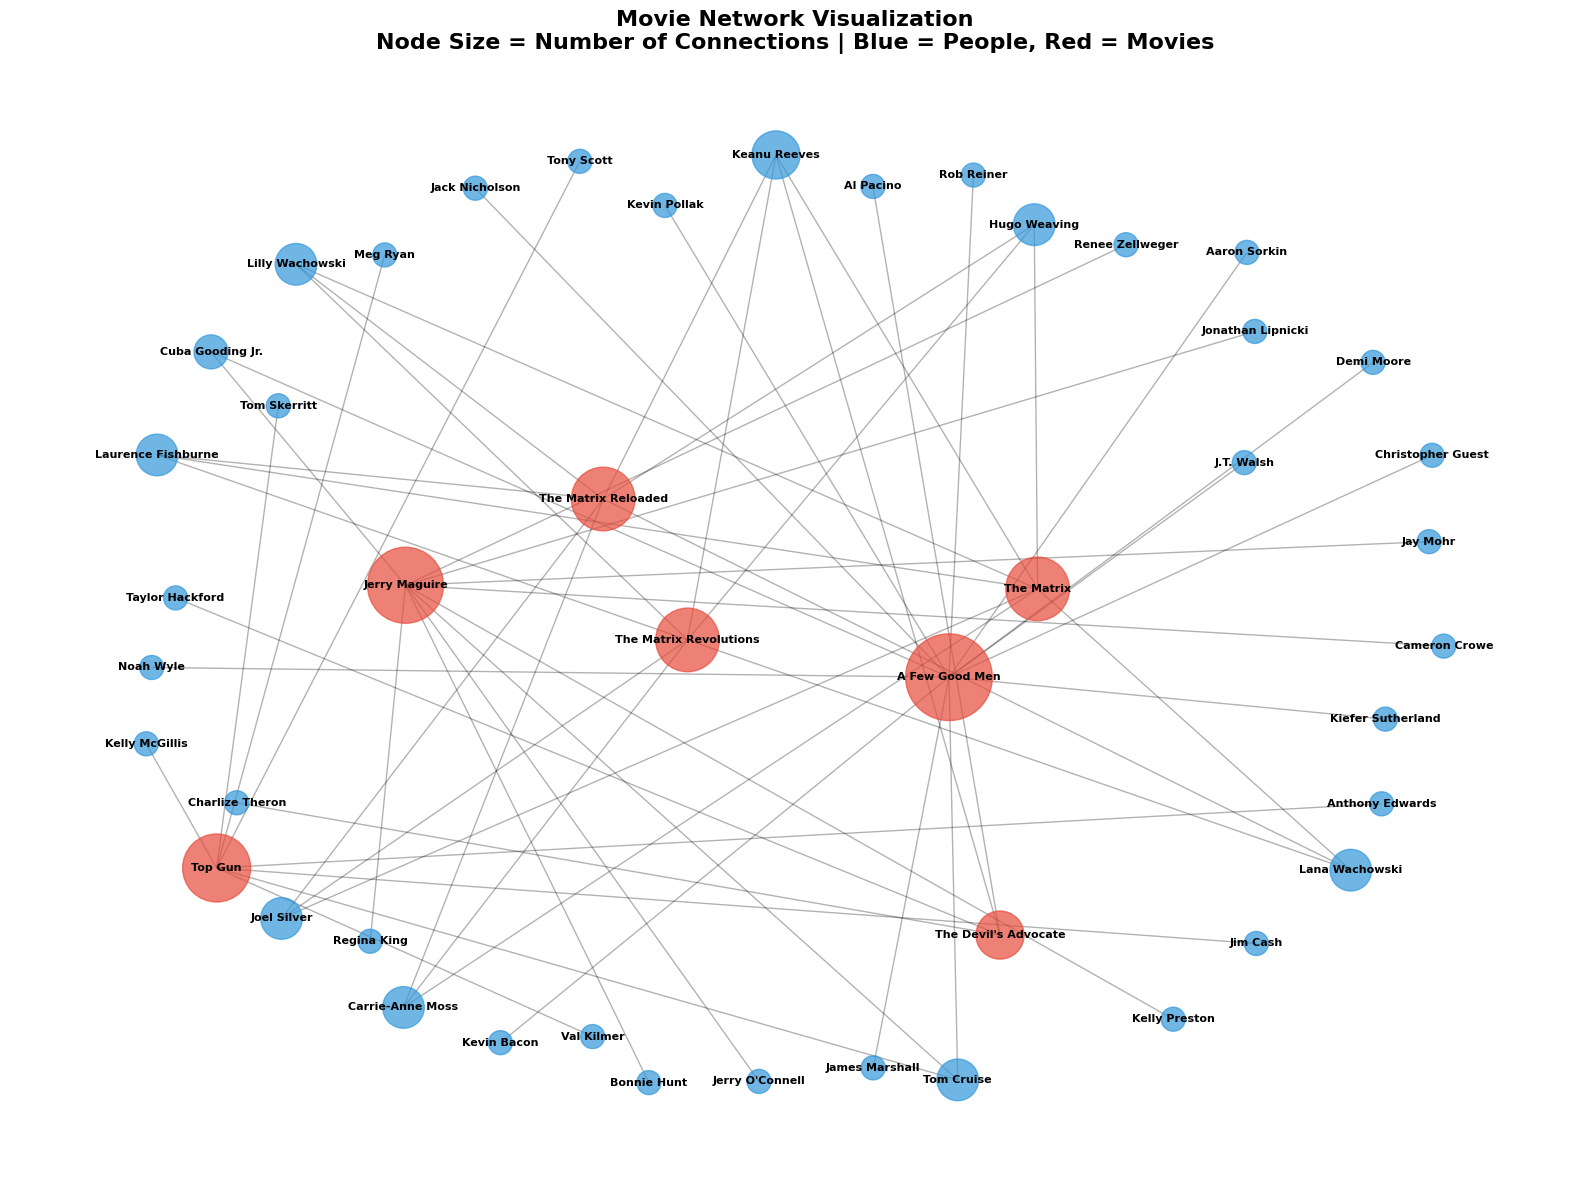


Observation: Notice the two separate clusters - they are not connected!


In [67]:
# Visualization 1: Full Network
fig, ax = plt.subplots(1, 1, figsize=(16, 12))

pos = nx.spring_layout(G, k=2, iterations=50, seed=42)

# Node sizes based on degree (number of connections)
node_sizes = [G.degree(node) * 300 for node in G.nodes()]

# Node colors: blue for people, red for movies
node_colors = ['#3498db' if node in person_nodes else '#e74c3c' for node in G.nodes()]

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors,
                       alpha=0.7, ax=ax)
nx.draw_networkx_edges(G, pos, alpha=0.3, ax=ax)
nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold', ax=ax)

ax.set_title("Movie Network Visualization\nNode Size = Number of Connections | Blue = People, Red = Movies",
              fontsize=16, fontweight='bold')
ax.axis('off')

plt.tight_layout()
plt.show()

print("\nObservation: Notice the two separate clusters - they are not connected!")

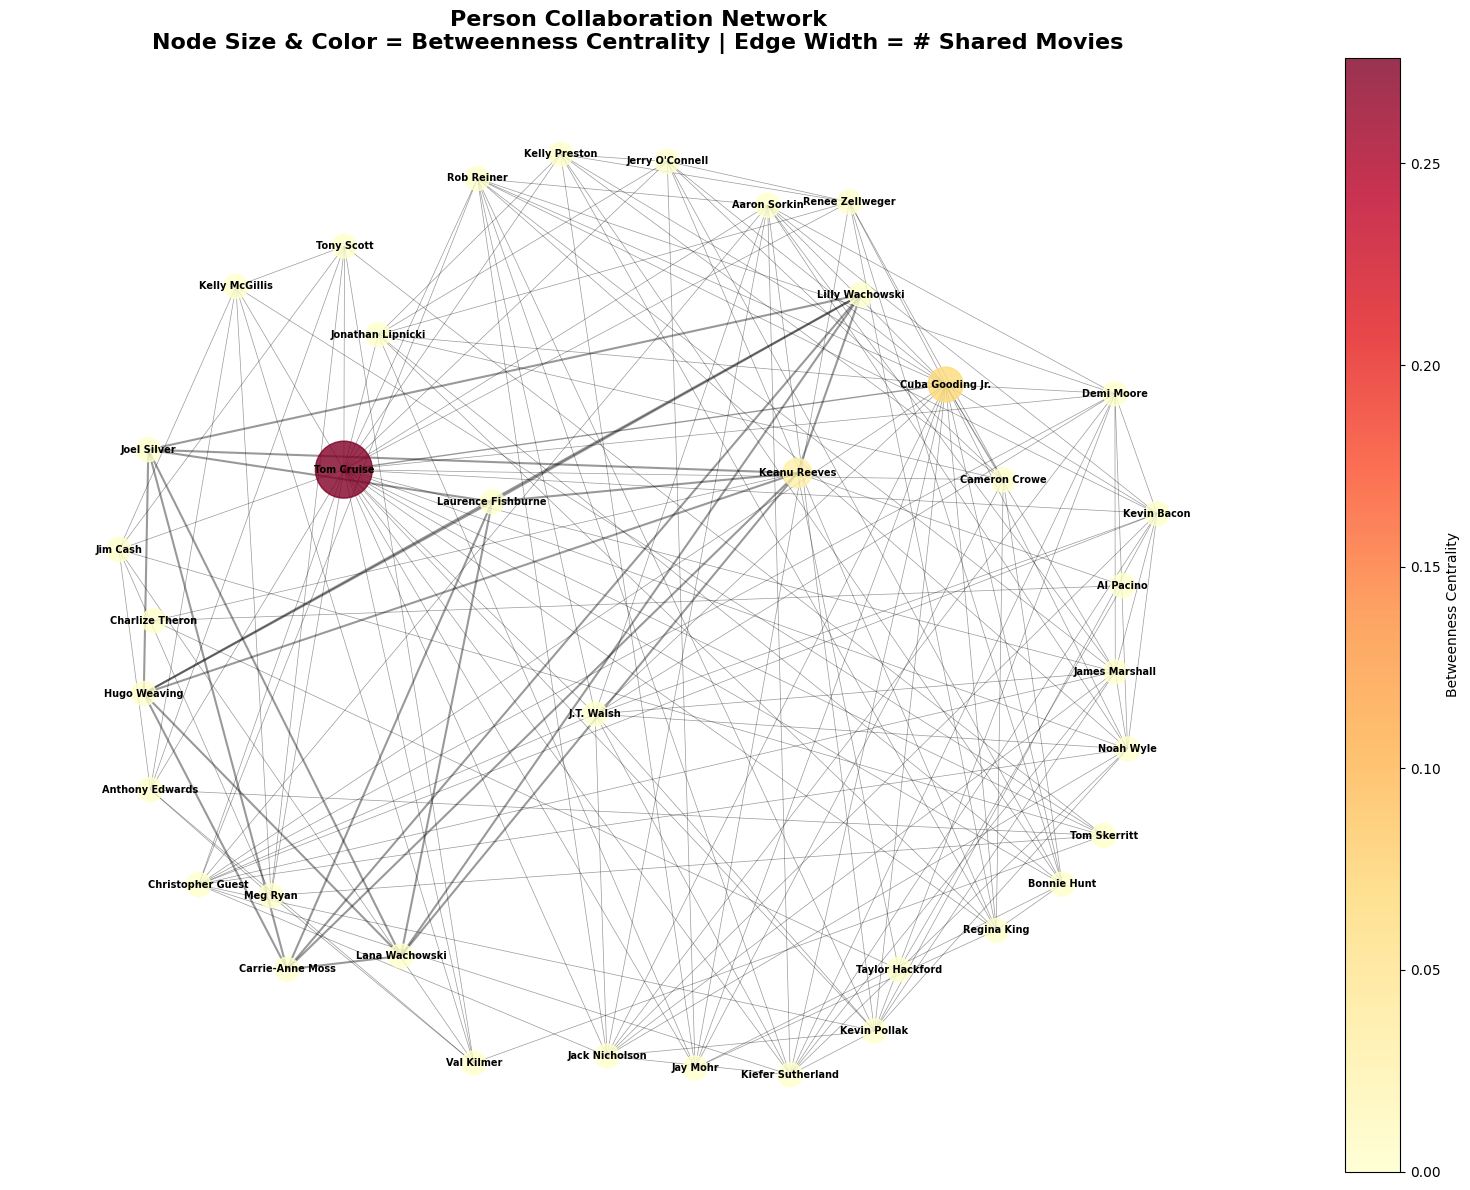


Observation: The darker/larger nodes are the critical bridges in the network!


In [68]:
# Visualization 2: Person-to-Person Network (Collaboration Graph)
# Create person-to-person projection (people connected if they share a movie)
person_graph = nx.Graph()

for person in person_nodes:
    person_graph.add_node(person)

# Connect people who worked on the same movie
for movie in movie_nodes:
    neighbors = list(G.neighbors(movie))
    people_in_movie = [n for n in neighbors if n in person_nodes]
    
    # Create edges between all pairs of people in this movie
    for i, p1 in enumerate(people_in_movie):
        for p2 in people_in_movie[i+1:]:
            if person_graph.has_edge(p1, p2):
                person_graph[p1][p2]['weight'] += 1
            else:
                person_graph.add_edge(p1, p2, weight=1)

# Calculate betweenness centrality
person_betweenness = nx.betweenness_centrality(person_graph)
max_betweenness = max(person_betweenness.values()) if person_betweenness.values() else 1

# Create visualization
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
pos = nx.spring_layout(person_graph, k=3, iterations=50, seed=42)

# Node sizes and colors based on betweenness centrality
node_sizes = [person_betweenness.get(node, 0) * 5000 + 300 for node in person_graph.nodes()]
node_colors = [person_betweenness.get(node, 0) for node in person_graph.nodes()]

nodes = nx.draw_networkx_nodes(person_graph, pos, node_size=node_sizes,
                               node_color=node_colors, cmap='YlOrRd',
                               alpha=0.8, ax=ax, vmin=0, vmax=max_betweenness)

# Edge widths based on collaboration count
edges = person_graph.edges()
weights = [person_graph[u][v]['weight'] for u, v in edges]
nx.draw_networkx_edges(person_graph, pos, width=[w*0.5 for w in weights],
                       alpha=0.4, ax=ax)
nx.draw_networkx_labels(person_graph, pos, font_size=7, font_weight='bold', ax=ax)

ax.set_title("Person Collaboration Network\nNode Size & Color = Betweenness Centrality | Edge Width = # Shared Movies",
              fontsize=16, fontweight='bold')
ax.axis('off')

plt.colorbar(nodes, ax=ax, label='Betweenness Centrality')
plt.tight_layout()
plt.show()

print("\nObservation: The darker/larger nodes are the critical bridges in the network!")

## Career Path Analysis

**Question**: Discover people who wore multiple hats in the film industry (e.g., acting, directing, producing, writing).

This query identifies multi-talented individuals and shows their career diversity across different roles.

In [70]:
# Find people with multiple roles (actor, director, producer, writer)
cypher = """
match (person: Person) -[r]- (movie: Movie)
with 
    person,
    collect(distinct type(r)) as roles,
    collect(distinct {movie: movie.title, year: movie.released, role: type(r)}) as credits
where size(roles) > 1  
unwind credits as credit
order by credit.year
with person, roles, collect(credit) as sorted_credits
return 
    person.name as person,
    roles as roles_held,
    size(roles) as role_diversity,
    sorted_credits as career_timeline
order by role_diversity desc, person.name
"""
result = kg.query(cypher)
df = pd.DataFrame(result)
print("Multi-talented individuals in the dataset:")
df

Multi-talented individuals in the dataset:


,person,roles_held,role_diversity,career_timeline
0,Cameron Crowe,"[DIRECTED, PRODUCED, WROTE]",3,"[{'movie': 'Jerry Maguire', 'role': 'DIRECTED'..."
1,Aaron Sorkin,"[ACTED_IN, WROTE]",2,"[{'movie': 'A Few Good Men', 'role': 'ACTED_IN..."


### Analysis

The results show:

- **Cameron Crowe**: Triple threat on "Jerry Maguire" - directed, produced, AND wrote it!
- **Aaron Sorkin**: Wrote "A Few Good Men" and also had a small acting role (cameo)

This demonstrates the power of graph queries to find:
1. People who transitioned between roles
2. Auteurs who control multiple aspects of filmmaking
3. Career evolution patterns

**Key Insight**: The query uses `UNWIND` to flatten the credits list and `ORDER BY credit.year` to create a chronological timeline - essential for tracking career progression!

---

# Summary: Key Learnings

## Essential Cypher Patterns

### 1. Basic Pattern Matching
```cypher
MATCH (node:Label {property: 'value'})
RETURN node
```
**Use case**: Find specific nodes or relationships

### 2. Aggregation Functions
- `COUNT()`: Count items
- `COLLECT()`: Group into lists
- `AVG()`, `MIN()`, `MAX()`: Statistics
- **Always use** `DISTINCT` when collecting to avoid duplicates

### 3. Avoiding Cartesian Products
```cypher
// Wrong: Creates duplicate rows
MATCH (person)-[:ACTED_IN]->(movie)
MATCH (movie)<-[:DIRECTED]-(director)

// Right: Use COLLECT to aggregate
MATCH (person)-[:ACTED_IN]->(movie)
OPTIONAL MATCH (movie)<-[:DIRECTED]-(director)
RETURN movie, COLLECT(DISTINCT director.name)
```

### 4. Path Finding
```cypher
MATCH path = shortestPath((a)-[:REL*]-(b))
RETURN path
```
- `*`: Variable-length paths
- `*..10`: Limit max path length
- `shortestPath()`: Find the shortest connection

### 5. Working with Arrays
```cypher
UNWIND array_property as item
RETURN item, COUNT(*)
```
**Critical for**: Analyzing properties that contain lists

---

## Graph Centrality Metrics

| Metric | What It Measures | When to Use |
|--------|------------------|-------------|
| **Degree Centrality** | Number of direct connections | Find most active/popular nodes |
| **Betweenness Centrality** | Appears in how many shortest paths | Find critical bridges/bottlenecks |
| **Closeness Centrality** | Average distance to all other nodes | Find nodes with quick access to network |
| **PageRank** | Importance based on incoming connections | Rank influence (like Google search) |

---

## Common Pitfalls

### 1. Disconnected Components
- Our dataset had 2 separate universes (Tom Cruise vs Keanu Reeves)
- **Always check**: Run connected components analysis first
- **Impact**: Centrality metrics can be misleading in disconnected graphs

### 2. MATCH vs OPTIONAL MATCH
- `MATCH`: Filters out nodes without the relationship (like INNER JOIN)
- `OPTIONAL MATCH`: Keeps all nodes (like LEFT JOIN)
- **Rule**: Use OPTIONAL MATCH when relationships might not exist

### 3. Performance Considerations
- Use labels to narrow searches: `MATCH (p:Person)` not `MATCH (p)`
- Limit variable-length paths: `[:REL*..10]` not `[:REL*]`
- Index frequently queried properties

---

## Real-World Applications

### Entertainment Industry
- Casting recommendations based on actor collaborations
- Identify successful director-actor partnerships
- Track career progressions and transitions

### Social Networks
- Find influencers (high centrality)
- Detect communities (connected components)
- Recommend connections (shortest path)

### Fraud Detection
- Identify suspicious patterns (unusual connections)
- Find money laundering networks (betweenness centrality)
- Trace transaction paths

### Knowledge Graphs
- Semantic search and recommendations
- Entity relationship mapping
- Question answering systems

---

## Next Steps

1. **Explore Neo4j Graph Data Science Library**: Advanced algorithms for PageRank, community detection, and more
2. **Try LangChain + GraphRAG**: Build AI applications that reason over graph data
3. **Load larger datasets**: Try the full recommendations dataset (28K+ nodes)
4. **Build visualizations**: Interactive graph exploration with tools like Neo4j Bloom

## Resources

- [Neo4j Cypher Manual](https://neo4j.com/docs/cypher-manual/)
- [Graph Data Science Library](https://neo4j.com/docs/graph-data-science/)
- [LangChain Neo4j Integration](https://python.langchain.com/docs/integrations/graphs/neo4j_cypher/)

---

**Congratulations!** You've learned the fundamentals of graph database querying and analysis with Neo4j and Cypher.